In [29]:
import sys
sys.path.append('/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt')
sys.path.append("/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt/Painter/SegGPT/SegGPT_inference")

import argparse
import os
import json
import torch as T
import torch.multiprocessing as mp

from agent import AgentAdapter
from typing import Dict
from utils import *
from data import OEMAdapterDataset, OEMAdapterDatasetV2, OEMAdapterDatasetV3
#from torch.distributed import init_process_group, destroy_process_group
#from torch.utils.data.distributed import DistributedSampler


In [30]:
from Painter.SegGPT.SegGPT_inference.models_seggpt import seggpt_vit_large_patch16_input896x448
from model import AdapterSegGPT

In [31]:

import torch as T
import argparse
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

In [32]:
config_path = "/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt/configs/adapter_single.json"

def get_args_parser(args=None):
    parser = argparse.ArgumentParser('SegGPT train adapter', add_help=False)
    parser.add_argument('--config', type=str, default=f'{config_path}', required=False)
    parser.add_argument('--port', type=int, help='DDP port', default=12355)
    parser.add_argument('--phase-2', action='store_true', help='phase 2 training, positive negative samples')
    parser.add_argument('--adapter-path', type=str, help='path to adapter checkpoint')
    parser.add_argument('--uid', type=str, help='unique id for the run', default=None)
    parser.add_argument('--lr', type=float, help='learning rate', default=None)
    parser.add_argument('--epoch', type=int, help='epoch', default=None)
    parser.add_argument('--ckpt-interval', type=int, help='checkpoint interval (in epoch)', default=None)
    return parser.parse_args([])

In [33]:
args = get_args_parser([])

In [34]:
args.config

'/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt/configs/adapter_single.json'

In [35]:
args.phase_2

False

In [36]:
train_args = json.load(open(args.config, 'r'))
train_args['adapter_path'] = args.adapter_path
train_args['phase_2'] = args.phase_2
if args.uid is not None:
    train_args['uid'] = args.uid
if args.lr is not None:
    train_args['lr'] = args.lr
if args.epoch is not None:
    train_args['epoch'] = args.epoch
if args.ckpt_interval is not None:
    train_args['ckpt_interval'] = args.ckpt_interval

In [37]:
train_dataset = OEMAdapterDatasetV3(
    root = train_args['train_dataset_dir'],
    mean = train_args['image_mean'],
    std = train_args['image_std'],
    resize = (1024, 1024),
    smallest_crop_size=train_args['smallest_crop_size'], 
    biggest_crop_size=train_args['biggest_crop_size'],
    smallest_stride=train_args['smallest_stride'],
    is_train=True,
    is_phase_2=train_args['phase_2'],
)
valid_dataset = OEMAdapterDatasetV3(
    root = train_args['train_dataset_dir'],
    mean = train_args['image_mean'],
    std = train_args['image_std'],
    resize = (1024, 1024),
    smallest_crop_size=train_args['smallest_crop_size'], 
    biggest_crop_size=train_args['biggest_crop_size'],
    smallest_stride=train_args['smallest_stride'],
    is_train=False,
    is_phase_2=train_args['phase_2'],
)


Caching images and grouping labels: 100%|██████████| 2/2 [00:00<00:00, 28.94it/s]


filename /home/eric/data/demoset/images/1.png
filename /home/eric/data/demoset/labels/1.png
filename /home/eric/data/demoset/images/2.png
filename /home/eric/data/demoset/labels/2.png
#--- preload
self.images 2


Caching images and grouping labels: 100%|██████████| 2/2 [00:00<00:00, 29.25it/s]

filename /home/eric/data/demoset/images/1.png
filename /home/eric/data/demoset/labels/1.png
filename /home/eric/data/demoset/images/2.png
filename /home/eric/data/demoset/labels/2.png
#--- preload
self.images 2


In [38]:
def torch_denormalize(img):
    img[0,:]  =  (img[0,:]* 0.229) + 0.485
    img[1,:]  =  (img[1,:]* 0.224) + 0.456
    img[2,:]  =  (img[2,:]* 0.225) + 0.406
    return img   

def torch_display(image,batch,denormal):
    '''
    input shape : batch or not  
    
    torch.Size([batch, channel, 256, 256])
    '''
    img = image.clone() 
    if batch:
        img = img[0,:]
    else:
        pass
    
    #----- denormalizing func
    if denormal:
        # [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        img = torch_denormalize(img)
    #-----
             
    img = img.permute(1,2,0)
    img = np.asarray(img)   
    
    fig_size= (10,10)
    plt.figure(figsize=fig_size)
    plt.imshow(img)

In [39]:
img, label, mask, valid, seg_type, ori_label, color_palette = train_dataset.__getitem__(0)

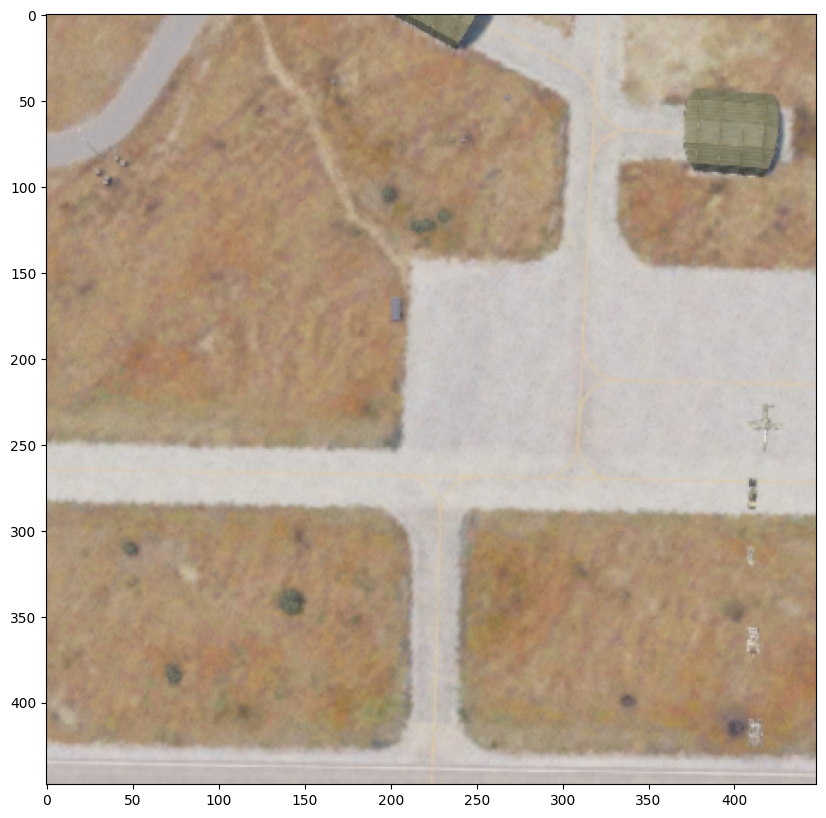

In [40]:
torch_display(img,False,True)

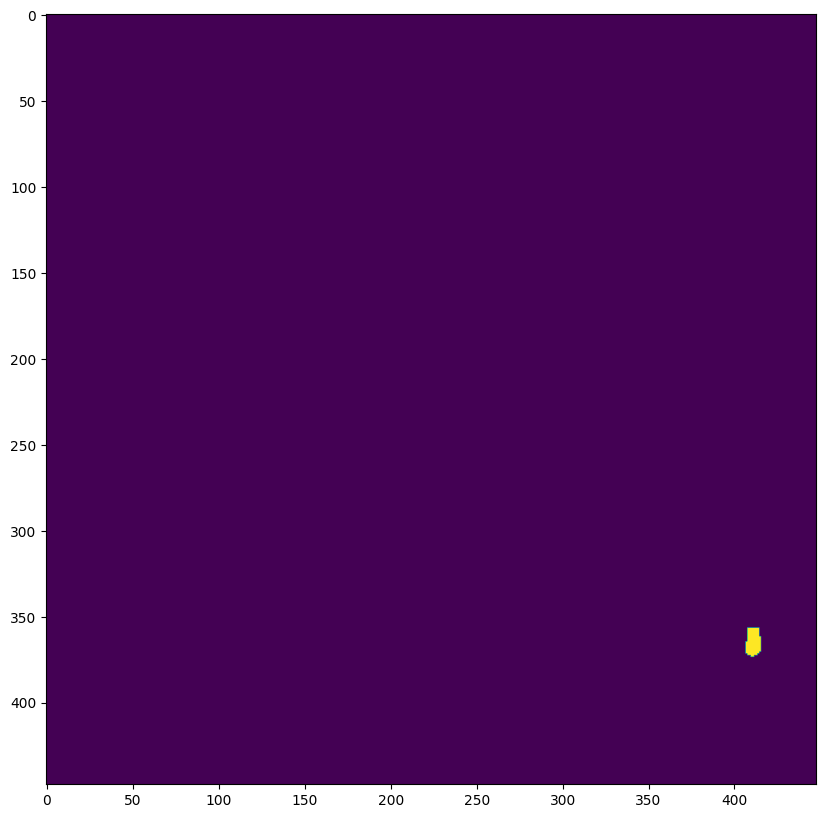

In [41]:
torch_display(ori_label.unsqueeze(0),False,False)

In [42]:
#--- 
# 원래는 0,1 되어야 하는데 255 되어도 그냥 해봄
torch.unique(ori_label)

tensor([  0., 255.])

In [43]:
from utils import *
setup_logging()
rank  = 0 
logger = get_logger(__name__, rank)

In [44]:
logger.info('Instantiating model and trainer agent')

INFO:__main__:Instantiating model and trainer agent


In [45]:
train_args['batch_size'],train_args['ddp']

(1, 'single')

In [46]:
logger.info('Instantiating dataloader')
train_dataloader = T.utils.data.DataLoader(
train_dataset,
batch_size=train_args['batch_size'],
shuffle=False,
num_workers=train_args['num_workers'],
pin_memory=True,
sampler=None,
)

valid_dataloader = T.utils.data.DataLoader(
valid_dataset,
batch_size=train_args['batch_size'],
shuffle=False,
num_workers=train_args['num_workers'],
pin_memory=True,
sampler=None,
)

INFO:__main__:Instantiating dataloader


In [47]:
seggpt_model = seggpt_vit_large_patch16_input896x448()
initial_ckpt = T.load(train_args['model_path'], map_location='cpu')
# vanilla seggpt 
seggpt_model.load_state_dict(initial_ckpt, strict = False)
# if mim base trained seggpt :
# seggpt_model.load_state_dict(initial_ckpt['model_state_dict'], strict=False)
model = AdapterSegGPT(seggpt_model)
logger.info('Frozen model loaded')

trainer = AgentAdapter(model, rank, train_args)


INFO:__main__:Frozen model loaded
INFO:Agent:======CONFIGURATIONS======
INFO:Agent:LR: 0.001
INFO:Agent:CYCLE_MULT: 1
INFO:Agent:LR_DECAY_FACTOR: 0.8
INFO:Agent:CYCLE_STEPS: 1000
INFO:Agent:WARMUP_STEPS: 50
INFO:Agent:MIN_LR: 1e-08
INFO:Agent:BATCH_SIZE: 1
INFO:Agent:EPOCH: 8
INFO:Agent:LOG_DIR: logs/1731146659
INFO:Agent:TRAIN_DATASET_DIR: /home/eric/data/demoset
INFO:Agent:VAL_DATASET_DIR: /home/eric/data/demoset
INFO:Agent:NUM_WORKERS: 4
INFO:Agent:EVAL_PER_EPOCH: 1
INFO:Agent:CKPT_INTERVAL: 2
INFO:Agent:IMAGE_MEAN: [0.485, 0.456, 0.406]
INFO:Agent:IMAGE_STD: [0.229, 0.224, 0.225]
INFO:Agent:IMAGE_LOG_INTERVAL: 200
INFO:Agent:MODEL_PATH: /disk3/eric/checkpoints/seggpt/seggpt_vit_large.pth
INFO:Agent:VALIDATION_RATIO: 0.1
INFO:Agent:SMALLEST_CROP_SIZE: 256
INFO:Agent:BIGGEST_CROP_SIZE: 512
INFO:Agent:SMALLEST_STRIDE: 64
INFO:Agent:DDP: single
INFO:Agent:ADAPTER_PATH: None
INFO:Agent:PHASE_2: False
INFO:Agent:CKPT_DIR: logs/1731146659/weights
INFO:Agent:Training config saved to logs/1

In [48]:
trainer.do_training(train_dataloader, valid_dataloader, train_args['eval_per_epoch'])

INFO:Agent:Epoch 1/8
INFO:Agent:Training Phase
  0%|          | 0/2 [00:00<?, ?it/s]


AttributeError: 'AdapterSegGPT' object has no attribute 'module'